# Многоклассовая классификация. KNN

## Анализ данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import joblib
model = '/content/drive/MyDrive/Datasets/best_model.pkl'

plt.style.use('ggplot')
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/NBC.csv')
data

,glucose,bloodpressure,diabetes
0,40,85,0
1,40,92,0
2,45,63,1
3,45,80,0
4,40,73,1
...,...,...,...
990,45,87,0
991,40,83,0
992,40,83,0
993,40,60,1


Проверим, есть ли пустые ячейки в датафрейме или нет

In [ ]:
data.empty

False

Пустые ячейки отсутствуют

In [ ]:
data.describe(include='all')

,glucose,bloodpressure,diabetes
count,995.000000,995.000000,995.000000
mean,44.306533,79.184925,0.500503
std,6.707567,9.340204,0.500251
min,20.000000,50.000000,0.000000
25%,40.000000,72.000000,0.000000
50%,45.000000,80.000000,1.000000
75%,50.000000,87.000000,1.000000
max,70.000000,100.000000,1.000000


<ipython-input-228-50af9fd40738>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x = 'diabetes', width = .2, palette = ['blue','green'])


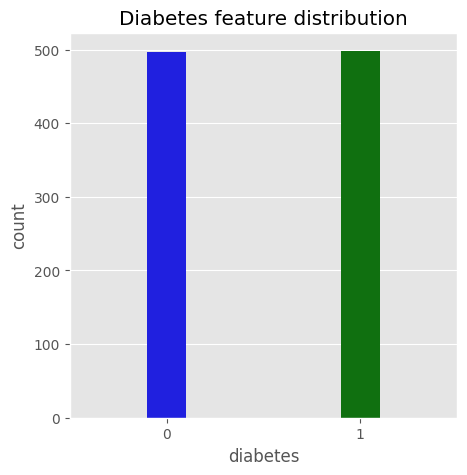

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(data=data, x = 'diabetes', width = .2, palette = ['blue','green'])
plt.title("Diabetes feature distribution")
plt.show()

## Преодобработка данных

Удалим дубликаты в данных и заменим NaN на 0

In [ ]:
data = data.drop_duplicates()
data

,glucose,bloodpressure,diabetes
0,40,85,0
1,40,92,0
2,45,63,1
3,45,80,0
4,40,73,1
...,...,...,...
873,20,73,1
914,55,87,0
953,40,75,0
955,45,50,1


Набор данных уменьшился, дубликаты были

<ipython-input-230-50af9fd40738>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x = 'diabetes', width = .2, palette = ['blue','green'])


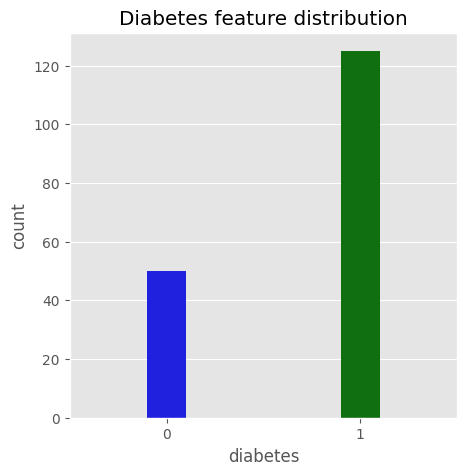

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(data=data, x = 'diabetes', width = .2, palette = ['blue','green'])
plt.title("Diabetes feature distribution")
plt.show()

In [ ]:
data.describe(include='all')

,glucose,bloodpressure,diabetes
count,175.000000,175.000000,175.000000
mean,44.485714,75.874286,0.714286
std,10.367864,10.515788,0.453050
min,20.000000,50.000000,0.000000
25%,40.000000,68.000000,0.000000
50%,45.000000,77.000000,1.000000
75%,50.000000,83.000000,1.000000
max,70.000000,100.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175 entries, 0 to 979
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   glucose        175 non-null    int64
 1   bloodpressure  175 non-null    int64
 2   diabetes       175 non-null    int64
dtypes: int64(3)
memory usage: 5.5 KB


# Функция для подсчета метрик качества модели многоклассовой классификации

In [ ]:
def calculate_classification_metrics(y_true, y_pred, y_pred_proba, model_name, threshold=None):

    metrics = {'Model': model_name}

    if len(np.unique(y_true)) == 2:  # Бинарная классификация
        if threshold is not None:
            y_pred_thresholded = (y_pred_proba[:, 1] >= threshold).astype(int)
            metrics['Accuracy'] = accuracy_score(y_true, y_pred_thresholded)
            metrics['ROC AUC'] = roc_auc_score(y_true, y_pred_proba[:, 1])
            metrics['Precision'] = precision_score(y_true, y_pred_thresholded)
            metrics['Recall'] = recall_score(y_true, y_pred_thresholded)
            metrics['F1 Score'] = f1_score(y_true, y_pred_thresholded)
            metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred_thresholded).tolist()
        else:
            metrics['Accuracy'] = accuracy_score(y_true, y_pred)
            metrics['ROC AUC'] = roc_auc_score(y_true, y_pred_proba[:, 1])
            metrics['Precision'] = precision_score(y_true, y_pred)
            metrics['Recall'] = recall_score(y_true, y_pred)
            metrics['F1 Score'] = f1_score(y_true, y_pred)
            metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()
    else:  # Многоклассовая классификация
        metrics['Accuracy'] = accuracy_score(y_true, y_pred)
        metrics['Precision (Micro)'] = precision_score(y_true, y_pred, average='micro')
        metrics['Recall (Micro)'] = recall_score(y_true, y_pred, average='micro')
        metrics['F1 Score (Micro)'] = f1_score(y_true, y_pred, average='micro')
        metrics['Precision (Macro)'] = precision_score(y_true, y_pred, average='macro')
        metrics['Recall (Macro)'] = recall_score(y_true, y_pred, average='macro')
        metrics['F1 Score (Macro)'] = f1_score(y_true, y_pred, average='macro')
        #metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()

    return metrics

# Функция поиска оптимального количества соседей

In [ ]:
def find_optimal_neighbors(X, y, max_neighbors):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    knn = KNeighborsClassifier()

    param_grid = {'n_neighbors': range(1, max_neighbors + 1)}

    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    optimal_neighbors = grid_search.best_params_['n_neighbors']

    return optimal_neighbors

# Функция для определения оптимального количества соседей и весов соседей

In [ ]:
def find_optimal_neighbors_and_weights(X, y, max_neighbors):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    knn = KNeighborsClassifier()

    param_grid = {
        'n_neighbors': range(1, max_neighbors + 1),
        'weights': ['uniform', 'distance']
    }

    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    optimal_neighbors = grid_search.best_params_

    return optimal_neighbors

# Обучение моделей (KNN)

## Модель №1

In [ ]:
X = data.drop(columns='diabetes')
y = data['diabetes']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Найдем оптимальное количество соседей

In [ ]:
optimal_neighbors = find_optimal_neighbors(X_train, y_train, max_neighbors = 25)

In [ ]:
print("Optimal number of neighbors:", optimal_neighbors)

Optimal number of neighbors: 7


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=optimal_neighbors, p=7, metric = 'euclidean')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)

In [ ]:
metrics_1 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass KNN №1')
print("Метрики качества модели:")
for metric, value in metrics_1.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass KNN №1
Accuracy: 0.7727272727272727
ROC AUC: 0.8321428571428572
Precision: 0.8125
Recall: 0.8666666666666667
F1 Score: 0.8387096774193549
Confusion Matrix: [[8, 6], [4, 26]]


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62        14
           1       0.81      0.87      0.84        30

    accuracy                           0.77        44
   macro avg       0.74      0.72      0.73        44
weighted avg       0.77      0.77      0.77        44



## Модель №2

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=optimal_neighbors, p=7, metric='manhattan')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)

In [ ]:
metrics_2 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass KNN №2')
print("Метрики качества модели:")
for metric, value in metrics_2.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass KNN №2
Accuracy: 0.7727272727272727
ROC AUC: 0.8321428571428572
Precision: 0.8125
Recall: 0.8666666666666667
F1 Score: 0.8387096774193549
Confusion Matrix: [[8, 6], [4, 26]]


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62        14
           1       0.81      0.87      0.84        30

    accuracy                           0.77        44
   macro avg       0.74      0.72      0.73        44
weighted avg       0.77      0.77      0.77        44



# Обучение моделей (Взвешанный KNN)

## Поиск оптимального количества соседей и весов соседей

In [ ]:
optimal_params = find_optimal_neighbors_and_weights(X_train, y_train, max_neighbors=25)
print("Optimal parameters:", optimal_params)

Optimal parameters: {'n_neighbors': 7, 'weights': 'uniform'}


## Модель №3

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=optimal_params['n_neighbors'], weights=optimal_params['weights'], p=7, metric='euclidean')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)

In [ ]:
metrics_3 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass Suspended KNN №3')
print("Метрики качества модели:")
for metric, value in metrics_3.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass Suspended KNN №3
Accuracy: 0.7727272727272727
ROC AUC: 0.8321428571428572
Precision: 0.8125
Recall: 0.8666666666666667
F1 Score: 0.8387096774193549
Confusion Matrix: [[8, 6], [4, 26]]


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62        14
           1       0.81      0.87      0.84        30

    accuracy                           0.77        44
   macro avg       0.74      0.72      0.73        44
weighted avg       0.77      0.77      0.77        44



## Модель №4

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=optimal_params['n_neighbors'], weights=optimal_params['weights'], p=7, metric='manhattan')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)

In [ ]:
metrics_4 = calculate_classification_metrics(y_test, y_pred, y_pred_proba, 'Model Multiclass Suspended KNN №4')
print("Метрики качества модели:")
for metric, value in metrics_4.items():
    print(f"{metric}: {value}")

Метрики качества модели:
Model: Model Multiclass Suspended KNN №4
Accuracy: 0.7727272727272727
ROC AUC: 0.8321428571428572
Precision: 0.8125
Recall: 0.8666666666666667
F1 Score: 0.8387096774193549
Confusion Matrix: [[8, 6], [4, 26]]


In [ ]:
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))


Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62        14
           1       0.81      0.87      0.84        30

    accuracy                           0.77        44
   macro avg       0.74      0.72      0.73        44
weighted avg       0.77      0.77      0.77        44



# Оценка моделей

In [ ]:
model_metrics_1_filtered = {key: value for key, value in metrics_1.items() if ((key != 'Model'))}

model_metrics_2_filtered = {key: value for key, value in metrics_2.items() if ((key != 'Model'))}

model_metrics_3_filtered = {key: value for key, value in metrics_3.items() if ((key != 'Model'))}

model_metrics_4_filtered = {key: value for key, value in metrics_4.items() if ((key != 'Model'))}

# Создание DataFrame
df = pd.DataFrame({
    "Model №1": model_metrics_1_filtered,
    "Model №2": model_metrics_2_filtered,
    "Model №3": model_metrics_3_filtered,
    "Model №4": model_metrics_4_filtered
})

# Функция для форматирования значений
def format_values(value):
    if isinstance(value, float):
        return "{:.8f}".format(value)
    else:
        return value

# Применение функции к каждому элементу DataFrame
df = df.applymap(format_values)

# Вывод DataFrame как красивой таблицы
display(df)

,Model №1,Model №2,Model №3,Model №4
Accuracy,0.77272727,0.77272727,0.77272727,0.77272727
ROC AUC,0.83214286,0.83214286,0.83214286,0.83214286
Precision,0.81250000,0.81250000,0.81250000,0.81250000
Recall,0.86666667,0.86666667,0.86666667,0.86666667
F1 Score,0.83870968,0.83870968,0.83870968,0.83870968
Confusion Matrix,"[[8, 6], [4, 26]]","[[8, 6], [4, 26]]","[[8, 6], [4, 26]]","[[8, 6], [4, 26]]"


# Сохрание лучшей модели

In [ ]:
joblib.dump(neigh, model)

['/content/drive/MyDrive/Datasets/best_model.pkl']

# Предсказание одного объекта

In [ ]:
neigh_best = joblib.load(model)

In [ ]:
import random
random_index = random.randint(0, len(X_test) - 1)
random_test_sample = X_test[random_index]
random_test_sample

array([-0.37606196,  0.55306773])

In [ ]:
true_label = y_test.iloc[random_index]
true_label

0

In [ ]:
neigh_best.predict(random_test_sample.reshape(1, -1))[0]

0

In [ ]:
# Получение вероятностей для каждого класса
predicted_probabilities = neigh_best.predict_proba(random_test_sample.reshape(1, -1))[0]

# Словарь для хранения меток классов и соответствующих вероятностей
class_probs = {}

# Заполнение словаря
for label, prob in zip(neigh_best.classes_, predicted_probabilities):
    class_probs[label] = prob

# Вывод меток классов и соответствующих вероятностей
for label, prob in class_probs.items():
    print(f"Class {label}: {prob}")

Class 0: 0.7142857142857143
Class 1: 0.2857142857142857


In [ ]:
neigh_best.kneighbors(random_test_sample.reshape(1, -1))

(array([[0.15507779, 0.19622612, 0.25223191, 0.39053436, 0.44654015,
         0.45264191, 0.45264191]]),
 array([[114,   7,  97,  44,  31,   8,  68]]))

In [ ]:
# Загрузка модели
neigh_best = joblib.load(model)

# Предсказание категории по входным данным
def predict_diabetes(glucose, bloodpressure):
    # Проверка диапазона для уровня глюкозы
    if not (20 <= glucose <= 70):
        return "Ошибка: уровень глюкозы должен быть в диапазоне от 20 до 70."

    # Проверка диапазона для уровня кровяного давления
    if not (50 <= bloodpressure <= 100):
        return "Ошибка: уровень кровяного давления должен быть в диапазоне от 50 до 100."

    # Создание вектора признаков на основе входных данных
    input_vector = [[glucose, bloodpressure]]

    # Предсказание класса
    prediction = neigh_best.predict(input_vector)[0]

    return prediction

# Пример использования
glucose = 70  # Пример уровня глюкозы
bloodpressure = 100  # Пример уровня кровяного давления

predicted_category = predict_diabetes(glucose, bloodpressure)
print("Результат предсказания:", predicted_category)

Результат предсказания: 0
